In [1]:
# pip install duckdb
# pip install jupysql
# pip install notebook
# pip install tabulate
# pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [3]:
# If on windows, this only works if you're running Jupyter as an admin
# pip install duckdb-engine

  Using cached duckdb_engine-0.13.1-py3-none-any.whl (47 kB)
  Using cached packaging-24.1-py3-none-any.whl (53 kB)
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9
Note: you may need to restart the kernel to use updated packages.


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import sqlalchemy
from datetime import date
import json
import pathlib
# import importlib
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [2]:
# Set up SQL connection
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Change the billboard_observation_date!

In [3]:
current_date = date.today().strftime('%Y-%m-%d')
billboard_observation_date = '2024-07-10'

In [5]:
# Replace with your filepath. Forward slashes work for both Mac and Windows
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

In [6]:
# Test connection
%sql USE raw_db;
%sql USE raw_db.billboard;
%sql SELECT * FROM raw_db.billboard.artist LIMIT 2;

,artist_id,artist_name,pct_female,last_update
0,1,Zach Bryan,0.0,2024-08-23
1,2,Morgan Wallen,0.0,2024-08-23


# Update upload/rank_by_name

In [7]:
# Update this for this week's rankings in upload/rank_by_name.py
# This is easier in an IDE that allows opt+arrow_key to move lines up and down

In [9]:
# TODO: figure out importlib.reload() here so I don't have to kill the kernel to reload
# from upload.rank_by_name import rankings
from upload.backfill_rank_by_name import rankings

if len(rankings) != 50:
    print(f'{len(rankings)} rankings, but expected 50')

rankings[:5] + ['...'] + rankings[45:]

['A Bar Song (Tipsy)',
 'I Had Some Help',
 'Cowgirls',
 'Pink Skies',
 'Pour Me A Drink',
 '...',
 'Coming Home',
 '28',
 "Song While You're Away",
 'Maxed Out',
 'Wanna Be Loved']

In [10]:
%%sql df_song_labeled <<
SELECT
    ss.song_id
    , ss.song_name
    , art.artist_name
    , s2a.relationship_type
    , ss.untracked_weeks_on_chart
FROM song ss
LEFT JOIN song_to_artist s2a
    ON ss.song_id = s2a.song_id
LEFT JOIN artist art
    ON s2a.artist_id = art.artist_id
;

In [11]:
existing_song_to_rank = {}
new_song_to_rank = {}
for song, rank_ix in zip(rankings, range(1,51)):
    n_rows = df_song_labeled[df_song_labeled['song_name'] == song]['song_id'].count()
    if n_rows == 0:
        new_song_to_rank[song] = rank_ix
    else:
        print(df_song_labeled.loc[df_song_labeled['song_name'] == song].to_markdown())
        song_id = input("Please enter the song_id or 'New Song'\n")

        if song_id == '': # hit enter to take the most common song ID
            song_id = int(
                df_song_labeled.loc[
                    df_song_labeled['song_name'] == song
                ]['song_id'].mode()
            )
        
        if str(song_id).lower() == 'new song':
            new_song_to_rank[song] = rank_ix
        else:
            existing_song_to_rank[int(song_id)] = rank_ix

|    |   song_id | song_name          | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:-------------------|:--------------|:--------------------|---------------------------:|
| 16 |        34 | A Bar Song (Tipsy) | Shaboozey     | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name       | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:----------------|:--------------|:--------------------|---------------------------:|
| 20 |        38 | I Had Some Help | Morgan Wallen | Other main artist   |                          0 |
| 92 |        38 | I Had Some Help | Post Malone   | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name   | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:------------|:--------------|:--------------------|-------------

Please enter the song_id or 'New Song'

|    |   song_id | song_name   | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:------------|:--------------|:--------------------|---------------------------:|
|  7 |        25 | Chevrolet   | Jelly Roll    | Featured artist     |                          1 |
| 89 |        25 | Chevrolet   | Dustin Lynch  | Lead artist         |                          1 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name        | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:-----------------|:--------------|:--------------------|---------------------------:|
| 21 |        39 | Beautiful As You | Thomas Rhett  | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name             | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:----------------------|:------------

In [12]:
# Check that you have 50 songs
print(len(existing_song_to_rank), '+')
print(json.dumps(new_song_to_rank, indent = 2))

43 +
{
  "Let Your Boys Be Country": 22,
  "The Man He Sees In Me": 34,
  "I'm Not Pretty": 37,
  "Smoke & A Light": 41,
  "Sun To Me": 44,
  "Coming Home": 46,
  "Song While You're Away": 48
}


## Add artists on any new songs that aren't in the artist table yet to its CSV

  "Let Your Boys Be Country": Jason Aldean,
  "The Man He Sees In Me": Luke Combs,
  "I'm Not Pretty": Megan Moroney,
  "Smoke & A Light": Ole 60,
  "Sun To Me": mgk,
  "Coming Home": Old Dominion,
  "Song While You're Away": Tyler Childers

In [13]:
df_artist = pd.read_csv('source_data/artist.csv')

In [20]:
new_song_artists = [
    'Jason Aldean' # 21
    , 'Luke Combs' # 6
    , 'Megan Moroney' # 4
    , 'Ole 60' # 66
    , 'mgk' # 29
    , 'Old Dominion' # 67
    , 'Tyler Childers' # 68
]
df_artist[df_artist['artist_name'].isin(new_song_artists)]

,artist_id,artist_name,pct_female,last_update
3,4,Megan Moroney,1.0,2024-08-23
5,6,Luke Combs,0.0,2024-08-23
20,21,Jason Aldean,0.0,2024-08-23
28,29,mgk,0.0,2024-08-23
65,66,Ole 60,0,2024-09-13
66,67,Old Dominion,0,2024-09-13
67,68,Tyler Childers,0,2024-09-13


In [16]:
df_artist['artist_id'].max()

65

In [18]:
df_artist = pd.concat(
    [
        df_artist
        , pd.DataFrame(
            np.array([
                [66, 'Ole 60', 0, current_date]
                , [67, 'Old Dominion', 0, current_date]
                , [68, 'Tyler Childers', 0, current_date]
            ])
            , columns = ['artist_id', 'artist_name', 'pct_female', 'last_update']
        )
    ]
    , ignore_index = True
)

In [19]:
df_artist.to_csv('source_data/artist.csv', index=False)

## Add all new songs to the song table CSV

In [21]:
df_song_raw = pd.read_csv('source_data/song.csv')

#### Paste new songs list here
  "Let Your Boys Be Country": Jason Aldean,
  "The Man He Sees In Me": Luke Combs,
  "I'm Not Pretty": Megan Moroney,
  "Smoke & A Light": Ole 60,
  "Sun To Me": mgk,
  "Coming Home": Old Dominion,
  "Song While You're Away": Tyler Childers

In [22]:
max_song_id = df_song_raw['song_id'].max()
array_new_songs = []
for song_name in [
    "Let Your Boys Be Country"
    , "The Man He Sees In Me"
    , "I'm Not Pretty"
    , "Smoke & A Light"
    , "Sun To Me"
    , "Coming Home"
    , "Song While You're Away"
]:
    max_song_id += 1
    array_new_songs += [[max_song_id, song_name, 0, current_date]]

array_new_songs

[[108, 'Let Your Boys Be Country', 0, '2024-09-13'],
 [109, 'The Man He Sees In Me', 0, '2024-09-13'],
 [110, "I'm Not Pretty", 0, '2024-09-13'],
 [111, 'Smoke & A Light', 0, '2024-09-13'],
 [112, 'Sun To Me', 0, '2024-09-13'],
 [113, 'Coming Home', 0, '2024-09-13'],
 [114, "Song While You're Away", 0, '2024-09-13']]

In [23]:
df_song_raw = pd.concat(
    [
        df_song_raw
        , pd.DataFrame(
            np.array(array_new_songs)
            , columns = ['song_id', 'song_name', 'untracked_weeks_on_chart', 'last_update']
        )
    ]
    , ignore_index = True
)

In [26]:
# Update untracked_weeks_on_chart if needed
df_song_raw[-len(array_new_songs)-1:]

,song_id,song_name,untracked_weeks_on_chart,last_update
106,107,Porch Light,0.0,2024-09-10
107,108,Let Your Boys Be Country,1,2024-09-13
108,109,The Man He Sees In Me,0,2024-09-13
109,110,I'm Not Pretty,20,2024-09-13
110,111,Smoke & A Light,0,2024-09-13
111,112,Sun To Me,0,2024-09-13
112,113,Coming Home,0,2024-09-13
113,114,Song While You're Away,0,2024-09-13


In [25]:
# Adjust untracked weeks if they aren't zero
# Ex. df_song_raw.loc[109, 'untracked_weeks_on_chart'] = 20

In [27]:
df_song_raw.to_csv('source_data/song.csv', index=False)

## Add all new songs to the song_to_artist table CSV

#### Paste new songs list here
  "Let Your Boys Be Country": Jason Aldean,
  "The Man He Sees In Me": Luke Combs,
  "I'm Not Pretty": Megan Moroney,
  "Smoke & A Light": Ole 60,
  "Sun To Me": mgk,
  "Coming Home": Old Dominion,
  "Song While You're Away": Tyler Childers

In [28]:
df_artist[df_artist['artist_name'].isin(new_song_artists)]

,artist_id,artist_name,pct_female,last_update
3,4,Megan Moroney,1.0,2024-08-23
5,6,Luke Combs,0.0,2024-08-23
20,21,Jason Aldean,0.0,2024-08-23
28,29,mgk,0.0,2024-08-23
65,66,Ole 60,0,2024-09-13
66,67,Old Dominion,0,2024-09-13
67,68,Tyler Childers,0,2024-09-13


In [29]:
df_s2a_raw = pd.read_csv('source_data/song_to_artist.csv').fillna('')

In [30]:
array_new_s2a = []
for s2a in [ # song_id, artist_id, relationship_conjunction, relationship_index
    [108, 21, '', '']
    , [109, 6, '', '']
    , [110, 4, '', '']
    , [111, 66, '', '']
    , [112, 29, '', '']
    , [113, 67, '', '']
    , [114, 68, '', '']
]:
    if s2a[3] == '': # Only lead artists don't have a relationship index
        reln = 'Lead artist'
    elif s2a[2] == '': # Featured artists don't have an explicit relationship conjunction
        reln = 'Featured artist' 
    else:
        reln = 'Other main artist'
        
    array_new_s2a += [[
        '-'.join([str(s2a[0]), reln, str(s2a[3])])
        , s2a[0]
        , s2a[1]
        , reln
        , s2a[2]
        , s2a[3]
        , current_date
    ]]
    
array_new_s2a

[['108-Lead artist-', 108, 21, 'Lead artist', '', '', '2024-09-13'],
 ['109-Lead artist-', 109, 6, 'Lead artist', '', '', '2024-09-13'],
 ['110-Lead artist-', 110, 4, 'Lead artist', '', '', '2024-09-13'],
 ['111-Lead artist-', 111, 66, 'Lead artist', '', '', '2024-09-13'],
 ['112-Lead artist-', 112, 29, 'Lead artist', '', '', '2024-09-13'],
 ['113-Lead artist-', 113, 67, 'Lead artist', '', '', '2024-09-13'],
 ['114-Lead artist-', 114, 68, 'Lead artist', '', '', '2024-09-13']]

In [31]:
df_s2a_raw = pd.concat(
    [
        df_s2a_raw
        , pd.DataFrame(
            np.array(array_new_s2a)
            , columns = [
                'song_to_artist_pk'
                , 'song_id'
                , 'artist_id'
                , 'relationship_type'
                , 'relationship_conjunction'
                , 'relationship_index'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
)

In [32]:
df_s2a_raw.tail(1)

,song_to_artist_pk,song_id,artist_id,relationship_type,relationship_conjunction,relationship_index,last_update
131,114-Lead artist-,114,68,Lead artist,,,2024-09-13


In [33]:
df_s2a_raw.to_csv('source_data/song_to_artist.csv', index=False)

## Convert new_song_to_rank to the id_to_rankix format of existing_song_to_rank
Then stack the two dicts of songs and insert to CSV with more info like current_date for last_update

In [34]:
all_song_to_rank = existing_song_to_rank.copy()
for song_name, rank in new_song_to_rank.items():
    songs = list(df_song_raw[df_song_raw['song_name'] == song_name]['song_id'])
    
    if len(songs) == 1:
        song_id = songs[0]
    elif len(songs) > 1:
        song_id = int(input(f'{str(songs)}: Choose ID of song actually at rank {rank}\n'))
    else:
        raise Exception(f'The song at rank {rank} is missing from the song CSV')
    
    all_song_to_rank[int(song_id)] = rank

In [35]:
array_new_ranking = [
    [
        '-'.join([billboard_observation_date, str(rank)])
        , billboard_observation_date
        , rank
        , song_id
        , current_date
    ]
    for song_id, rank
    in all_song_to_rank.items()
]

array_new_ranking[45:] # should be 5 rows

[['2024-07-10-37', '2024-07-10', 37, 110, '2024-09-13'],
 ['2024-07-10-41', '2024-07-10', 41, 111, '2024-09-13'],
 ['2024-07-10-44', '2024-07-10', 44, 112, '2024-09-13'],
 ['2024-07-10-46', '2024-07-10', 46, 113, '2024-09-13'],
 ['2024-07-10-48', '2024-07-10', 48, 114, '2024-09-13']]

In [36]:
df_billboard_ranking_raw = pd.concat(
    [
        pd.read_csv('source_data/billboard_ranking.csv').fillna('')
        , pd.DataFrame(
            np.array(array_new_ranking)
            , columns = [
                'billboard_ranking_pk'
                , 'billboard_observation_date'
                , 'billboard_rank'
                , 'song_id'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
)

In [37]:
df_billboard_ranking_raw.to_csv('source_data/billboard_ranking.csv', index=False)

## Push to duckdb

In [38]:
# TODO: instead of purging and rebuilding, use the raw data to run updates
%sql --close duckdb:///C:/Users/Admin/billboard/raw_db.duckdb --quiet
pathlib.Path('raw_db.duckdb').unlink(missing_ok = True)

TODO: integrate into jupyter using `%python`

In a command terminal
- `python table_configs/run_schema_configs.py billboard_schema.sql`
- `python table_configs/run_table_configs.py`
- `python main.py`

## Run the ranking SQL script

In [39]:
with duckdb.connect('raw_db.duckdb') as conn:
    with open('analysis/artist_ranking.sql') as sql_file:
        artist_ranking = conn.sql(sql_file.read())
    
    # TODO: Grab headers from the SQL too
    df_artist_ranking = pd.DataFrame(artist_ranking.fetchall())

In [40]:
pd.set_option('display.max_rows', 100)
df_artist_ranking

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,Zach Bryan,86,86,86,110,110,110,21,21,21,21,21,21,4.0,4.0,2024-07-10,1
1,15,Post Malone,59,59,59,59,59,59,18,18,18,18,18,18,2.0,2.0,2024-07-10,2
2,2,Morgan Wallen,19,29,39,31,41,51,2,3,4,2,3,4,2.0,2.0,2024-07-10,3
3,16,Koe Wetzel,20,20,20,20,20,20,2,2,2,2,2,2,9.0,9.0,2024-07-10,4
4,5,Jelly Roll,14,20,33,14,20,34,3,4,6,3,4,6,9.0,9.0,2024-07-10,5
5,6,Luke Combs,18,18,26,53,53,61,3,3,5,4,4,6,3.0,3.0,2024-07-10,6
6,4,Megan Moroney,17,17,17,37,37,37,4,4,4,4,4,4,21.0,21.0,2024-07-10,7
7,11,Lainey Wilson,15,15,18,15,50,53,2,2,3,2,3,4,19.0,19.0,2024-07-10,8
8,8,Bailey Zimmerman,15,15,15,15,15,15,2,2,2,2,2,2,27.0,27.0,2024-07-10,9
9,25,Shaboozey,12,12,12,12,12,12,2,2,2,2,2,2,1.0,1.0,2024-07-10,10


In [41]:
with duckdb.connect('raw_db.duckdb') as conn:
    print(conn.sql(
        """
        SELECT billboard_observation_date, COUNT(1) n
        FROM raw_db.billboard.billboard_ranking
        GROUP BY 1
        ORDER BY 1 DESC
        """
    ))

┌────────────────────────────┬───────┐
│ billboard_observation_date │   n   │
│            date            │ int64 │
├────────────────────────────┼───────┤
│ 2024-09-10                 │    50 │
│ 2024-09-05                 │    50 │
│ 2024-08-27                 │    50 │
│ 2024-08-23                 │    50 │
│ 2024-08-13                 │    50 │
│ 2024-08-07                 │    50 │
│ 2024-07-31                 │    50 │
│ 2024-07-23                 │    50 │
│ 2024-07-16                 │    50 │
│ 2024-07-10                 │    50 │
├────────────────────────────┴───────┤
│ 10 rows                  2 columns │
└────────────────────────────────────┘



In [44]:
# TODO: Set comparison_observation_date as num weeks back, not specific date
current_observation_date = '2024-07-16' # or current_date
comparison_observation_date = '2024-07-10'

with duckdb.connect('raw_db.duckdb') as conn:
    with open('analysis/removed_songs.sql') as sql_file:
        removed_songs = conn.sql(
            sql_file.read().format(
                current_observation_date
                , comparison_observation_date
            )
        )
    print(removed_songs)

┌─────────┬────────────────────────────────────────┬────────────────┐
│ song_id │               song_name                │ ranking_before │
│  int32  │                varchar                 │     int32      │
├─────────┼────────────────────────────────────────┼────────────────┤
│     108 │ Let Your Boys Be Country               │             22 │
│      49 │ Relapse                                │             30 │
│      35 │ Worst Way                              │             32 │
│     109 │ The Man He Sees In Me                  │             34 │
│      31 │ What He'll Never Have                  │             35 │
│     110 │ I'm Not Pretty                         │             37 │
│      33 │ Love You, Miss You, Mean It            │             39 │
│      44 │ She's Somebody's Daughter (Reimagined) │             40 │
│     111 │ Smoke & A Light                        │             41 │
│      72 │ Indifferent                            │             42 │
│      93 │ Boys Bac

In [ ]:
# TODO add a measurement start date column for Friday of each week based on observation date

# Scratch work to get song sparklines

In [95]:
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

In [96]:
%%sql df_a_song <<
SELECT
    br.billboard_observation_date
    , br.song_id
    , ss.song_name
    , br.billboard_rank
FROM raw_db.billboard.billboard_ranking br
LEFT JOIN raw_db.billboard.song ss
    ON br.song_id = ss.song_id
WHERE br.song_id IN (63, 64) -- # Out Of Oklahoma, Guy For That
ORDER BY 1 ASC
;

In [97]:
df_a_song

,billboard_observation_date,song_id,song_name,billboard_rank
0,2024-07-31,63,Out Of Oklahoma,45
1,2024-08-07,64,Guy For That,7
2,2024-08-07,63,Out Of Oklahoma,43
3,2024-08-13,64,Guy For That,12
4,2024-08-13,63,Out Of Oklahoma,41
5,2024-08-23,64,Guy For That,12
6,2024-08-23,63,Out Of Oklahoma,40
7,2024-08-27,64,Guy For That,7
8,2024-09-05,64,Guy For That,11
9,2024-09-10,64,Guy For That,12


In [98]:
%sql --close duckdb:///C:/Users/Admin/billboard/raw_db.duckdb --quiet

In [105]:
df_a_song.pivot(
        index='billboard_observation_date'
        , columns='song_name'
        , values='billboard_rank'
    ).fillna(np.inf)

song_name,Guy For That,Out Of Oklahoma
billboard_observation_date,,
2024-07-31,inf,45.0
2024-08-07,7.0,43.0
2024-08-13,12.0,41.0
2024-08-23,12.0,40.0
2024-08-27,7.0,inf
2024-09-05,11.0,inf
2024-09-10,12.0,50.0


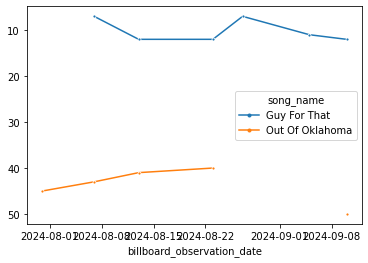

In [123]:
n_lines = 2 # TODO use df.count()

# TODO scale up size
# TODO a line for every song by an artist
# TODO loop through artists
# TODO dash type based on s2a relationship type
graph = sns.lineplot(
    data = df_a_song.pivot(
        index='billboard_observation_date'
        , columns='song_name'
        , values='billboard_rank'
    ).fillna(np.inf) # hide hidden data // TODO: show points with null immediately before and after
    , markers=['.'] * n_lines
    , dashes=False
    # , hue='k' # Not working with error 'cannot be assigned with wide-form data'
)
graph.axes.invert_yaxis()